In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import csv
import heapq
import jellyfish
import sys
import datetime as datetime
import string
from gensim import *
import recordlinkage as rl
import sklearn
from recordlinkage.standardise import clean
import pickle
import gensim
import numpy as np
import warnings
import pandas
import numpy
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import NotFittedError
from sklearn.ensemble import *
from xgboost import XGBClassifier
import math, time
from joblib import Parallel, delayed
import numpy as np
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from itertools import chain
from collections import Counter
import math
import os
import sys
import logging
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import multiprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from IPython.display import HTML

pd.set_option('display.max_columns', 300)

def jarowinkler_similarity(s1, s2):
    
    conc = pd.concat([s1, s2], axis=1, ignore_index=True)
    def jaro_winkler_apply(x):
        try:
            return jellyfish.jaro_winkler(x[0], x[1])
        except Exception as err:
            if pd.isnull(x[0]) or pd.isnull(x[1]):
                return np.nan
            else:
                raise err
    return conc.apply(jaro_winkler_apply, axis=1)

def postcode_block(data_one, data_two, block_key):
    
    # create candidate record pairs
    pcl_blocks = rl.Pairs(data_one, data_two)
    # block on postcode
    pairs = pcl_blocks.block(left_on=block_key, right_on=block_key)
    parts = []
    start_slice = 0
    while start_slice <= len(pairs):
        # Set the end of the slice
        end_slice = start_slice + 1
        # Slice the MultiIndex 
        m_ind = pairs[start_slice:end_slice]
        ind = m_ind.get_level_values(0)
        # The actual indexing
        index_result = data_one.loc[ind]
        # Append to list named parts
        parts.append(index_result)
        # Set new slice start
        start_slice = end_slice  
    data_one_rl = pd.concat(parts, axis=0, copy=False)
    data_one_rl.index = pairs
    return data_one_rl

def all_addresses(training=False, word2vec=False):
    
    def null_check(string):
        if pd.notnull(string) and string[0].isdigit():
            return 'unit ' + str(string)
        else:
            return np.nan

    headers = ['id','bic', 'ndr', 'ba', 'desc_code', 'desc', 'uarn', 'prop_id', 'firm_name', 'num', 'street', 'town', 'post_dist', 'county', 'PostCode', 'eff_date', 'comp_ind', 'rateable_val', 'appeal_code', 'assess_ref', 'alt_date', 'scat_code', 'sub_lev3', 'sub_lev2', 'sub_lev1', 'case_no', 'curr_from', 'curr_to']
    
    ldc_potential_fields = ['b_NameFull','ad_Building_Unit','ad_Building','ad_Building_Floor', 'ad_shop_centre','ad_StreetNo','ad_StreetNo2','ad_Street','ad_City','region', 'ad_Zip']
    voa_potential_fields = ['num', 'street', 'town', 'post_dist', 'county', 'PostCode']

    # use training data to test string matching
    if training == True:
        
        voa_2010 = pd.read_csv('./data/voa2010.csv', 
                 na_values='', 
                 sep='\r', 
                 delimiter = '*', 
                 encoding='latin_1', 
                 names=headers, 
                 index_col=False)

        # lookup tables
        replacements = {'BEDS':'bedfordshire',
                        'HERTS':'hertfordshire',
                        'WILTS':'wiltshire',
                        'BUCKS':'buckinghamshire',
                        'OXON':'oxfordshire',
                        'BERKS':'berkshire',
                        'GLOS':'gloucestershire',
                        'CAMBS':'cambridgeshire',
                        'LINCS':'lincolnshire',
                        'HANTS':'hampshire',
                        'NOTTS':'nottinghamshire',
                        'LANCS':'lancashire',
                        'STAFFS':'staffordshire',
                        'LEICS':'leicestershire',
                        'WORCS':'worcestershire',
                        'DEVON':'devonshire',
                        'MIDDX':'middlesex',
                        'NORTHANTS':'northamptonshire',
                        'NORTHD':'northumberland',
                        'CO DURHAM':'county durham'
                       }

        voa_2010['county'] = voa_2010['county'].replace(replacements)

        
        # load data and normalize to VOA to assist comparison
        ldc_df = pd.read_csv('./data/ldc_data.csv', dtype=str)
        ldc_df['ad_StreetNo'] = ldc_df[['ad_StreetNo','ad_StreetLetter']].fillna('').apply(lambda x: ''.join(x), axis=1)
        ldc_df['ad_StreetNo2'] = ldc_df[['ad_StreetNo2','ad_StreetLetter2']].fillna('').apply(lambda x: ''.join(x), axis=1)
        ldc_df[['ad_StreetNo', 'ad_StreetNo2']] = ldc_df[['ad_StreetNo', 'ad_StreetNo2']].replace('', np.nan)

        # if unit column starts with a number, append unit prefix 
        ldc_df['ad_Building_Unit'] = ldc_df.ad_Building_Unit.apply(lambda x: null_check(x))
        
        # concatenate street numbers where there is secodnary street number
        ldc_df['ad_StreetNo'] = ldc_df['ad_StreetNo'].astype(str)

        # Create a mask of those addresses having an additional street number.
        mask = ldc_df.loc[ldc_df['ad_StreetNo2'].notnull()]

        # Use the mask to append the additional street number.
        ldc_df.loc[mask.index, 'ad_StreetNo'] += '-' + ldc_df.loc[mask.index, 'ad_StreetNo2'].astype(str)

        # Set the additional  number to NaN.
        ldc_df.loc[mask.index, 'ad_StreetNo2'] = np.nan

        # keep ldc records with UARN key
        ldc_uarn = ldc_df[pd.notnull(ldc_df['V_UARN'])]

        ldc_uarn.V_UARN = ldc_uarn.V_UARN.astype(str)
        voa_2010.uarn = voa_2010.uarn.astype(str)

        # merge to create training data
        training = pd.merge(voa_2010, ldc_uarn, how='inner', left_on='uarn', right_on='V_UARN')

        # create validation set
        uarns = [str(i) for i in training.uarn.values.tolist()]
        voa_validation = voa_2010[voa_2010['uarn'].apply(str).isin(uarns)]
        ldc_validation = ldc_df[ldc_df['V_UARN'].isin(training['V_UARN'].values.tolist())]
        
        if word2vec == False:
            voa_validation = pd.DataFrame({'uarn': voa_validation['uarn'],'address': (voa_validation.apply(lambda r: ', '.join([str(r[c]).strip().replace('.0','').lower() for c in voa_potential_fields if not pd.isnull(r[c])]),axis=1)),'postcode':voa_validation['PostCode']})
            ldc_validation = pd.DataFrame({'uarn': ldc_validation['V_UARN'] ,'address': (ldc_validation.apply(lambda r: ', '.join([str(r[c]).strip().replace('.0','').lower() for c in ldc_potential_fields if not pd.isnull(r[c])]),axis=1)),'postcode':ldc_validation['ad_Zip']})
        elif word2vec == True:
            voa_validation = pd.DataFrame({'uarn': voa_validation['uarn'],'address': (voa_validation.apply(lambda r: ' '.join([str(r[c]).strip().replace('.0','').lower() for c in voa_potential_fields if not pd.isnull(r[c])]),axis=1)),'postcode':voa_validation['PostCode']})
            ldc_validation = pd.DataFrame({'uarn': ldc_validation['V_UARN'] ,'address': (ldc_validation.apply(lambda r: ' '.join([str(r[c]).strip().replace('.0','').lower() for c in ldc_potential_fields if not pd.isnull(r[c])]),axis=1)),'postcode':ldc_validation['ad_Zip']})
        
        
        all_address = voa_validation['address'].append(ldc_validation['address'],ignore_index=True)

        return [ldc_validation, voa_validation, all_address]
    
    else:
        voa_data = pd.read_csv('./data/list_entries.csv', 
                         na_values='', 
                         sep='\r', 
                         delimiter = '*', 
                         encoding='latin_1', 
                         names=headers, 
                         index_col=False)
        
        ldc_data = pd.read_csv('./data/ldc_data.csv',header=0)

        # ldc_addresses = ldc_data.apply(lambda r: ' '.join([str(r[c]).strip().replace('.0','').lower() for c in ldc_potential_fields if not pd.isnull(r[c])]),axis=1)
        ldc_addresses = pd.DataFrame({'address': (ldc_data.apply(lambda r: ' '.join([str(r[c]).strip().replace('.0','').lower() for c in ldc_potential_fields if not pd.isnull(r[c])]),axis=1)),'postcode':ldc_data['ad_Zip']})
        voa_addresses = pd.DataFrame({'address':(voa_data['prop_id']+ ' ' + voa_data['PostCode']).astype(str).map(lambda x:x.replace(',','').lower()).fillna(''), 'postcode':voa_data['PostCode']})

        all_address = voa_addresses['address'].append(ldc_addresses['address'],ignore_index=True)

        return [ldc_addresses, voa_addresses, all_address]
    
def matching(groups, propensity_scores):
    
    # code groups as 0 and 1
    N = len(y)
    N1 = int(y.sum())
    N2 = N - N1
    g1, g2 = propensity_scores[0:N1], propensity_scores[N1:]
    morder = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.NAN
    if N1 > N2:
        N1, N2, g1, g2 = N2, N1, g2, g1 
    for m in morder:
        dist = abs(g1[m] - g2)
        matches[m] = dist.argmin()
        g2 = g2.drop(matches[m])
    
    return matches

def tfidf_similarity(s1, s2):
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_extraction.text import CountVectorizer

    tfidf = TfidfVectorizer(analyzer = 'word', min_df=1)

    tfidf.fit(all_address_train)
    tfidf_lookup = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

    conc = pd.concat([s1, s2], axis=1, ignore_index=True)
    
    def tfidf_apply(x):
        try:
            a1_tokens = x[0].split()
            a2_tokens = x[1].split()
            
            # get intersection tokens
            intersection = getIntersection(a1_tokens, a2_tokens)

            if intersection:
                # calculate similarity score based on rareness of tokens
                similarity = computeSimilarity(x[0], x[1], intersection)
            else:
                similarity = 0
            return similarity
        except Exception as err:
            if pd.isnull(x[0]) or pd.isnull(x[1]):
                return np.nan
            else:
                raise err
    
    def getIntersection(s1,s2):
        return set(s1).intersection(s2)

    def computeUniqueness(s, isToken = True):
        if not isToken:
            if s in lookup_uniqueness:
                return lookup_uniqueness[s]
            tokens = s.split()
        else:
            tokens = s
        score = 1
        for t in tokens:
            if t in tfidf_lookup:
                score += tfidf_lookup[t]
        if not isToken:
            lookup_uniqueness[s] = score
        return score

    def computeSimilarity(s1,s2,intersection):
        return computeUniqueness(intersection)/((computeUniqueness(s1,isToken=False)*computeUniqueness(s2,isToken=False))**0.5)

    return conc.apply(tfidf_apply, axis=1)
        
def reduction_ratio(n, x):

    def max_pairs(shape):

        if not isinstance(shape, (tuple, list)):
            n = _max_pairs_deduplication(_get_len(shape))

        elif (isinstance(shape, (tuple, list)) and len(shape) == 1):
            n = _max_pairs_deduplication(_get_len(shape[0]))

        else:
            n = _max_pairs_linkage([_get_len(xi) for xi in shape])

        return n

    n_max = max_pairs(x)

    if isinstance(n, pandas.MultiIndex):
        n = len(n)

    if n > n_max:
        raise ValueError("n has to be smaller of equal n_max")


    return 1 - n / n_max

def specificity(confusion_matrix):

    v = confusion_matrix[1, 1] \
        / (confusion_matrix[1, 1] + confusion_matrix[1, 0])

    return float(v)

def false_positive_rate(confusion_matrix):

    v = confusion_matrix[1, 0] \
        / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
    
    return float(v)

def precision(confusion_matrix):

    v = confusion_matrix[0, 0] \
        / (confusion_matrix[0, 0] + confusion_matrix[1, 0])

    return float(v)


def recall(confusion_matrix):


    v = confusion_matrix[0, 0] \
        / (confusion_matrix[0, 0] + confusion_matrix[0, 1])

    return float(v)

def fscore(confusion_matrix):

    prec = precision(confusion_matrix)
    rec = recall(confusion_matrix)

    return float(2 * prec * rec / (prec + rec))

def true_positives(true_match_index, matches_index):

    return len(true_match_index & matches_index)


def true_negatives(true_match_index, matches_index, n_pairs):

    if not isinstance(n_pairs, (int, float)):
        n_pairs = len(n_pairs)

    return int(n_pairs) - len(true_match_index | matches_index)


def false_positives(true_match_index, matches_index):

    # The classified matches without the true matches.
    return len(matches_index.difference(true_match_index))


def false_negatives(true_match_index, matches_index):

    return len(true_match_index.difference(matches_index))

def confusion_matrix(true_match_index, matches_index, n_pairs):
    """Compute the confusion matrix.
    The confusion matrix is of the following
    form:
    +---------------------+-----------------------+----------------------+
    |                     |  Predicted Positive   | Predicted Negatives  |
    +=====================+=======================+======================+
    | **True Positive**   | True Positives (TP)   | False Negatives (FN) |
    +---------------------+-----------------------+----------------------+
    | **True Negative**   | False Positives (FP)  | True Negatives (TN)  |
    +---------------------+-----------------------+----------------------+
    """

    # True positives
    tp = true_positives(true_match_index, matches_index)

    # True negatives
    tn = true_negatives(true_match_index, matches_index, n_pairs)

    # False positives
    fp = false_positives(true_match_index, matches_index)

    # False negatives
    fn = false_negatives(true_match_index, matches_index)

    return np.array([[tp, fn], [fp, tn]])

class LearningError(Exception):
    """Learning error"""

class Classifier(object):

    def __init__(self):

        self.classifier = None

    def learn(self, comparison_vectors, match_index, return_type='index'):

        if isinstance(match_index, (pandas.MultiIndex, pandas.Index)):

            # The match_index variable is of type MultiIndex
            train_series = pandas.Series(False, index=comparison_vectors.index)

            try:
                train_series.loc[match_index & comparison_vectors.index] = True

            except pandas.IndexError as err:

                # The are no matches. So training is not possible.
                if len(match_index & comparison_vectors.index) == 0:
                    raise LearningError(
                        "both matches and non-matches needed in the" +
                        "trainingsdata, only non-matches found"
                    )
                else:
                    raise err

        self.classifier.fit(
            comparison_vectors.as_matrix(),
            numpy.array(train_series)
        )
                                
        return self.predict(comparison_vectors, return_type)
    
    def predict_proba(self, comparison_vectors):
        
        y_pred = self.classifier.predict_proba(comparison_vectors)
    
        return y_pred
    
    
    def predict(self, comparison_vectors, return_type='index'):

        try:
            prediction = self.classifier.predict(
                comparison_vectors.as_matrix())
        except NotFittedError:
            raise NotFittedError(
                "This {} is not fitted yet. Call 'learn' with appropriate "
                "arguments before using this method.".format(
                    type(self).__name__
                )
            )

        return self._return_result(prediction, return_type, comparison_vectors)
    
    def _return_result(
        self, result, return_type='index', comparison_vectors=None
    ):


        if type(result) != numpy.ndarray:
            raise ValueError("numpy.ndarray expected.")

        # return the pandas.MultiIndex
        if return_type == 'index':
            return comparison_vectors.index[result.astype(bool)]

        # return a pandas.Series
        elif return_type == 'series':
            return pandas.Series(
                result,
                index=comparison_vectors.index,
                name='classification')

        # return a numpy.ndarray
        elif return_type == 'array':
            return result

        # return_type not known
        else:
            raise ValueError(
                "return_type {} unknown. Choose 'index', 'series' or "
                "'array'".format(return_type))

from sklearn import cluster, linear_model

class RandomForestClassifierRl(Classifier):

    def __init__(self, trees, features, *args, **kwargs):
        super(self.__class__, self).__init__(*args, **kwargs)
        
        # initialise with model params
        self.trees = trees
        self.max_feature = features

        self.classifier = RandomForestClassifier(n_estimators=trees, max_features=features)
        
    def feature_importance(self):

        importances = self.classifier.feature_importances_

        return importances
    
    def estimator(self):
        
        est = self.classifier.estimators_

        return est

class LogisticRegressionClassifierRl(Classifier):

    def __init__(self, coefficients=None, intercept=None):
        super(self.__class__, self).__init__()

        self.classifier = linear_model.LogisticRegression()

        self.coefficients = coefficients
        self.intercept = intercept

        self.classifier.classes_ = numpy.array([False, True])

    @property
    def params(self):
        return {
            'coefficients': self.coefficients,
            'intercept': self.intercept
        }

    @params.setter
    def params(self, value):

        if not isinstance(value, dict):
            raise ValueError("parameters are of wrong type")

        self.coefficients = value['coefficients']
        self.interceptall_addresses = value['intercept']

    @property
    def coefficients(self):
        # Return the coefficients if available
        try:
            return list(self.classifier.coef_[0])
        except Exception:
            return None

    @coefficients.setter
    def coefficients(self, value):

        if value is not None:

            # Check if array if numpy array
            if type(value) is not numpy.ndarray:
                value = numpy.array(value)

            self.classifier.coef_ = value.reshape((1, len(value)))

    @property
    def intercept(self):

        try:
            return float(self.classifier.intercept_[0])
        except Exception:
            return None

    @intercept.setter
    def intercept(self, value):

        if value is not None:

            if not isinstance(value, (list)):
                value = numpy.array(value)
            else:
                value = numpy.array([value])

            self.classifier.intercept_ = value

        # value is None
        elif value is None:
            try:
                del self.classifier.intercept_
            except AttributeError:
                pass
        else:
            raise ValueError('incorrect type')

class XGBClassifierRl(Classifier):

    def __init__(self, n_boosted_trees,*args, **kwargs):
        super(self.__class__, self).__init__(*args, **kwargs)
        
        self.n_boosted_trees = n_boosted_trees
        
        # initialise with model params
        self.classifier = XGBClassifier(n_estimators=n_boosted_trees)
        
def avg_feature_vector(words, weight_avg=False):

    featureVec = np.zeros((100,), dtype="float32")
    nwords = 0
    # list containing names of words in the vocabulary
    index2word_set = set(paf_w2v.wv.index2word) 
    for word in words:
        if word in index2word_set: 
            
            if weight_avg == True:
                
                if frequency_table[word] == 1:
                    tfidf = 1/math.log(1.5)
                else:
                    tfidf = 1/math.log(frequency_table[word])
        
            else:
                # compute per-document tfidf
                tfidf_values = dict(tfidf_model[dictionary.doc2bow(words)])
                tfidf = tfidf_values[dictionary.token2id[word]]
            
            # weight by proportional importance 
            word_vec = tfidf * paf_w2v[word]
                        
            featureVec = np.add(featureVec, word_vec)
        
            nwords = nwords+1
        
    if(nwords>0):
#         featureVec = np.sum(featureVec)
        featureVec = np.divide(featureVec, nwords)
    
    return featureVec
    
def joblib_loop(data):
    return Parallel(n_jobs=20)(delayed(avg_feature_vector)(words=address.split()) for i,address in enumerate(data))

def show_confusion_matrix(name, C,class_labels=['Match','Non-match']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tp = C[0,0]; fn = C[0,1]; fp = C[1,0]; tn = C[1,1];
    
    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.coolwarm)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,1,
            'False Pos Rate: %.5f'%(fp/(tn+fp)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,0,
            'True Pos Rate: %.5f'%(tp/(tp+fn)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    prec = precision(C)
    rec = recall(C)

    ax.text(2,2,
            'F1 Score: %.5f'%(float(2 * prec * rec / (prec + rec))),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Recall: %.5f'%(tp/(tp+fn)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Precision: %.5f'%(tp/(tp+fp)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.savefig(name, dpi=200)
    plt.show()
    
    

def calc_inbag(n_samples, forest, n_trees):

    inbag = np.zeros((n_samples, n_trees))
    sample_idx = []
    for t_idx in range(n_trees):
        sample_idx.append(
            _generate_sample_indices(forest.estimator()[t_idx].random_state,
                                     n_samples))
        inbag[:, t_idx] = np.bincount(sample_idx[-1], minlength=n_samples)
    return inbag


def _bias_correction(V_IJ, inbag, pred_centered, n_trees):
    n_train_samples = inbag.shape[0]
    n_var = np.mean(np.square(inbag[0:n_trees]).mean(axis=1).T.view() -
                    np.square(inbag[0:n_trees].mean(axis=1)).T.view())
    boot_var = np.square(pred_centered).sum(axis=1) / n_trees
    bias_correction = n_train_samples * n_var * boot_var / n_trees
    V_IJ_unbiased = V_IJ - bias_correction
    return V_IJ_unbiased
        
def random_forest_error(forest, X_train, X_test, n_trees, inbag=None,
                        memory_constrained=False, memory_limit=10000):

    if inbag is None:
        inbag = calc_inbag(X_train.shape[0], forest, n_trees)
        
    pred = np.array([tree.predict(X_test) for tree in forest.estimator()]).T
    pred_mean = np.mean(pred, 0)
    pred_centered = pred - pred_mean
        
    chunk_size = int((memory_limit * 1e6) /(8.0 * X_train.shape[0]))
    
    chunk_edges = np.arange(0,X_test.shape[0]+chunk_size,chunk_size)
    inds = range(X_test.shape[0])
    chunks = [inds[chunk_edges[i]:chunk_edges[i+1]] 
              for i in range(len(chunk_edges)-1)]
    print('Number of chunks: %d' % (len(chunks),))
    V_IJ = np.concatenate([np.sum((np.dot(inbag-1,
                                          pred_centered[chunk].T)/n_trees)**2,0)
                           for chunk in chunks])
        
        
        
    V_IJ_unbiased = _bias_correction(V_IJ, inbag, pred_centered, n_trees)
    
    if np.max(inbag) == 1:
        variance_inflation = 1 / (1 - np.mean(inbag)) ** 2
        V_IJ_unbiased *= variance_inflation

    return V_IJ_unbiased
    
# dict for tfidf storage
lookup_uniqueness = {}

<h2>Supervised Classifier</h2>

Random Forests Results: 

[[ 27630    156]
 [   158 124742]]

Recall:    0.9943856618440942
Precision: 0.9943140924139916
F1 Score:  0.9943498758412207
Specificity:  0.9987349879903923
False Positive Rate:  0.0012650120096076862

1. tfidf_score  (8) (0.470417)
2. city_jaro  (1) (0.248009)
3. road_jaro  (0) (0.166458)
4. house_number_jaro  (3) (0.109326)
5. house_jaro  (2) (0.005604)
6. suburb_jaro  (6) (0.000130)
7. unit_jaro  (7) (0.000052)
8. state_jaro  (5) (0.000003)
9. level_jaro  (4) (0.000002)


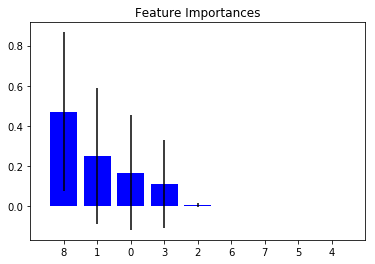

XGBoost Results: 

[[ 27659    127]
 [   158 124742]]

Recall:    0.9954293529115382
Precision: 0.9943200201315742
F1 Score:  0.9948743772818013
Specificity:  0.9987349879903923
False Positive Rate:  0.0012650120096076862

Logistic Regression Results:

[[ 27496    290]
 [   206 124694]]

Recall:    0.9895630893255596
Precision: 0.9925637138112772
F1 Score:  0.9910611303344867
Specificity:  0.9983506805444355
False Positive Rate:  0.0016493194555644516


LogisticRegressionClassifierRl



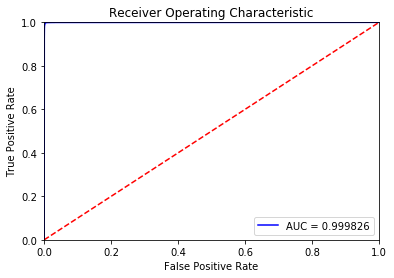


RandomForestClassifierRl



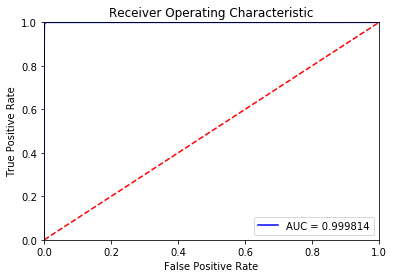

In [3]:
# load training data
ldc_training, voa_training, all_address_train = all_addresses(training=True, word2vec=False)

from postal.parser import parse_address

# parse address for each cleaned voa record
ldc_training_lib = [parse_address(i) for i in ldc_training.address]
voa_training_lib = [parse_address(i) for i in voa_training.address]

# build df from list of list of tuples
ldc_training_lib = pd.DataFrame.from_records([{k: v for v, k in row} for row in ldc_training_lib]).add_suffix('_ldc')
voa_training_lib = pd.DataFrame.from_records([{k: v for v, k in row} for row in voa_training_lib]).add_suffix('_voa')

# get libpostal segmentation for both address sets then join by uarn key
ldc_training_merge = ldc_training.reset_index()
ldc_training_merge = pd.merge(ldc_training_merge, ldc_training_lib, left_index=True, right_index=True)

voa_training_merge = voa_training.reset_index(drop=True)
voa_training_merge = pd.merge(voa_training_merge, voa_training_lib, left_index=True, right_index=True)

# merge training data on uarn key
comp_vec = pd.merge(ldc_training_merge, voa_training_merge, left_on='uarn', right_on='uarn')

# use left to index LDC and UARN to index VOA
comp_vec.set_index([comp_vec.index, 'uarn'], inplace=True)

# column labels to list
cols = list(comp_vec.columns)

######### DATA AUGMENTATION STEP ###########

shuffle_ldc = comp_vec[cols[0:19]] # voa columns
shuffle_voa = comp_vec[cols[19:]] # ldc columns

shuffle_ldc = shuffle_ldc.reset_index(drop=True)
shuffle_voa = shuffle_voa.reset_index(drop=True)

# create REAL index to reference back
shuffle_ldc.insert(0, 'ldc_index', range(221484, 221484 + len(shuffle_ldc)))
shuffle_voa.insert(0, 'voa_index', range(332226, 332226 + len(shuffle_voa)))

# shuffle indexes 
ldc_shuffle = shuffle_ldc.reindex(np.random.permutation(shuffle_ldc.index))
voa_shuffle = shuffle_voa.reindex(np.random.permutation(shuffle_voa.index))

# sample with replacement here
ldc_shuffle = ldc_shuffle.sample(500000, replace=True)
voa_shuffle = voa_shuffle.sample(500000, replace=True)

# create FAKE index to link
ldc_shuffle['new_ind'] = list(range(len(voa_shuffle)))
voa_shuffle['new_ind'] = list(range(len(voa_shuffle)))

voa_shuffle = voa_shuffle.set_index(['new_ind'])
ldc_shuffle = ldc_shuffle.set_index(['new_ind'])

# join shuffled indexes for synthetic non-matches
non_matches = voa_shuffle.join(ldc_shuffle)
non_matches = non_matches.reset_index(drop=True)

# set indexes as same to ground truth data
non_matches.set_index(['voa_index', 'ldc_index'], inplace=True)

comp_vec_train = comp_vec.append(non_matches)

########### END OF DATA AUGMENTATION ####################

# build feature columns
comp_vec_train['category_jaro'] = jarowinkler_similarity(comp_vec_train.category_ldc, comp_vec_train.category_voa)
comp_vec_train['road_jaro'] = jarowinkler_similarity(comp_vec_train.road_ldc, comp_vec_train.road_voa)
comp_vec_train['city_jaro'] = jarowinkler_similarity(comp_vec_train.city_ldc, comp_vec_train.city_voa)
comp_vec_train['city_district_jaro'] = jarowinkler_similarity(comp_vec_train.city_district_ldc, comp_vec_train.city_district_voa)
comp_vec_train['house_jaro'] = jarowinkler_similarity(comp_vec_train.house_ldc, comp_vec_train.house_voa)
comp_vec_train['house_number_jaro'] = jarowinkler_similarity(comp_vec_train.house_number_ldc, comp_vec_train.house_number_voa)
comp_vec_train['level_jaro'] = jarowinkler_similarity(comp_vec_train.level_ldc, comp_vec_train.level_voa)
comp_vec_train['near_jaro'] = jarowinkler_similarity(comp_vec_train.near_ldc, comp_vec_train.near_voa)
comp_vec_train['postcode_jaro'] = jarowinkler_similarity(comp_vec_train.postcode_ldc, comp_vec_train.postcode_voa)
comp_vec_train['state_jaro'] = jarowinkler_similarity(comp_vec_train.state_ldc, comp_vec_train.state_voa)
comp_vec_train['state_district_jaro'] = jarowinkler_similarity(comp_vec_train.state_district_ldc, comp_vec_train.state_district_voa)
comp_vec_train['suburb_jaro'] = jarowinkler_similarity(comp_vec_train.suburb_ldc, comp_vec_train.suburb_voa)
comp_vec_train['unit_jaro'] = jarowinkler_similarity(comp_vec_train.unit_ldc, comp_vec_train.unit_voa)
comp_vec_train['tfidf_score'] = tfidf_similarity(comp_vec_train.address_x, comp_vec_train.address_y)

# create comparison vector dataframe
comp_vec_train[['road_jaro',
                'city_jaro',
                'city_district_jaro',
                'house_jaro',
                'house_number_jaro',
                'level_jaro',
                'near_jaro',
                'postcode_jaro',
                'state_jaro',
                'state_district_jaro',
                'suburb_jaro',
                'unit_jaro',
                'tfidf_score']]

# insert match index for identifying matches and non_matches
comp_vec_train.insert(0, 'match_index_status', range(0, 0 + len(comp_vec_train)))

def is_matched(df):
    if df['match_index_status'] < len(comp_vec):
        return 1
    else:
        return 0

# apply match status 
comp_vec_train['match_status'] = comp_vec_train.apply(is_matched, axis=1)

# use 75% / 25% train:test split
from sklearn.model_selection import train_test_split

training_set, test_set = train_test_split(comp_vec_train, test_size = 0.25)

# removed features are category, city district, near deduced from feature importance plot (see later)
training_set = training_set[['road_jaro',
                'city_jaro',
                'house_jaro',
                'house_number_jaro',
                'level_jaro',
#                 'postcode_jaro',
                'state_jaro',
#                 'state_district_jaro',
                'suburb_jaro',
                'unit_jaro',
                'tfidf_score',
                'match_status']].fillna('0.0')

test_set = test_set[['road_jaro',
                'city_jaro',
                'house_jaro',
                'house_number_jaro',
                'level_jaro',
#                 'postcode_jaro',
                'state_jaro',
#                 'state_district_jaro',
                'suburb_jaro',
                'unit_jaro',
                'tfidf_score',
                'match_status']].fillna('0.0')

# create golden pairs indexes for training all methods
golden_matches_index = training_set.drop('match_status',axis=1).index & comp_vec.index 

############## RANDOM FORESTS ##############

# define RF classifier, specifying parameters
rfc = RandomForestClassifierRl(trees=1000, features='sqrt') # trees = 1000 , m = sqrt(p)

# train rf classifier on training
rfc.learn(training_set.drop('match_status',axis=1), golden_matches_index) # drop match status so it is not evalauted

# evaluate of testing
result_trained_rf = rfc.predict(test_set.drop('match_status',axis=1)) # drop match status so it is not evalauted

# get true match indexes for validation
true_match_index = test_set[test_set['match_status'] == 1].index

# define  size of test set
n_pairs = len(test_set)

# construct confusion matrix using 'gold matches' from test set and classified links
conf_rf = confusion_matrix(true_match_index, result_trained_rf, n_pairs)

print('\033[32m' + 'Random Forests Results: ' + '\033[0m')
print('') #space
print(conf_rf)
print('') #space
print('Recall:   ',recall(conf_rf))
print('Precision:',precision(conf_rf))
print('F1 Score: ',fscore(conf_rf))
print('Specificity: ', specificity(conf_rf))
print('False Positive Rate: ', false_positive_rate(conf_rf))
print('') #space

# retrieve feature importances
importances = rfc.feature_importance()

#retrieve variance of estiamtor measures
std = np.std([tree.feature_importances_ for tree in rfc.estimator()],
             axis=0)
indices = np.argsort(importances)[::-1]
labels = list(zip(test_set.drop('match_status',axis=1), rfc.feature_importance()))

for f in range(test_set.drop('match_status', axis=1).shape[1]):
    print("%d. %s  (%d) (%f)" % (f + 1, labels[indices[f]][0], indices[f], importances[indices[f]]))
    
plt.figure()
plt.title("Feature Importances")
plt.bar(range(test_set.drop('match_status', axis=1).shape[1]), 
        importances[indices],
        yerr=std[indices],
        color="b", 
        align="center")
plt.xticks(range(test_set.drop('match_status', axis=1).shape[1]), indices)
plt.xlim([-1, test_set.drop('match_status', axis=1).shape[1]])
plt.show()


############## XGBOOST ##############

xgb = XGBClassifierRl(n_boosted_trees=1000)
xgb.learn(training_set.drop('match_status',axis=1), golden_matches_index) #train

result_xgb = xgb.predict(test_set.drop('match_status',axis=1)) # test
conf_xgb = confusion_matrix(true_match_index, result_xgb, n_pairs) # evaluate

print('\033[32m' + 'XGBoost Results: ' + '\033[0m')
print('') #space
print(conf_xgb)
print('') #space
print('Recall:   ',recall(conf_xgb))
print('Precision:',precision(conf_xgb))
print('F1 Score: ',fscore(conf_xgb))
print('Specificity: ', specificity(conf_xgb))
print('False Positive Rate: ', false_positive_rate(conf_xgb))
print('') #space

############## LOGIT ##############

logreg = LogisticRegressionClassifierRl() # define
logreg.learn(training_set.drop('match_status',axis=1), golden_matches_index) #train

result_logreg = logreg.predict(test_set.drop('match_status',axis=1)) # test
conf_log = confusion_matrix(true_match_index, result_logreg, n_pairs) # evaluate

print('\033[32m' + 'Logistic Regression Results:' + '\033[0m')
print('') #space
print(conf_log)
print('') #space
print('Recall:   ',recall(conf_log))
print('Precision:',precision(conf_log))
print('F1 Score: ',fscore(conf_log))
print('Specificity: ', specificity(conf_log))
print('False Positive Rate: ', false_positive_rate(conf_log))
print('') #space

############# ROC CURVES ############

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = [logreg, rfc]

for model in models:
    
    name = repr(model).split(' ')[0].split('.')[1]
    
    print('')
    print('\033[32m' + name + '\033[0m')
    print('')

    # true labels
    y_pred = model.predict_proba(test_set.drop('match_status',axis=1))[:, 1]
    
    # probabilities estiamtes for classes
    y_test = np.asarray(test_set['match_status'].tolist())

    # define ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # area under curve parameterised by false positive rate and true positive rate
    roc_auc = auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

<h3>Feature correlation</h3>

In [8]:
import seaborn as sns

test = test_set.drop('match_status',axis=1).reset_index(drop=1)

test.columns = ['road', 'city', 'house', 'house_number',
       'level', 'state', 'state_district', 'suburb',
       'unit', 'tfidf']

f, ax = plt.subplots(figsize=(10, 8))
corr = test.astype(float).corr()
sns.heatmap(corr, cmap='RdBu_r')

plt.xticks(rotation=90)

ValueError: Length mismatch: Expected axis has 9 elements, new values have 11 elements

<h3>Random forest variance estimates</h3>

In [ ]:
import forestci as fci
from sklearn.ensemble.forest import _generate_sample_indices

# set number of trees
n_trees = 1000

# compute rf error
rfc_unbiased = random_forest_error(rfc,
                                   train, 
                                   test,
                                   n_trees)

# get predicted values
pred_y_hat = rfc.predict_proba(test_set.drop('match_status',axis=1))

# plot for matches and non-matches
idx = np.where(test_set['match_status'] == 1)[0]
plt.errorbar(pred_y_hat[idx, 1], np.sqrt(rfc_unbiased[idx]), 
             fmt='.', alpha=0.50, label='Match',c='green')

idx = np.where(test_set['match_status'] == 0)[0]
plt.errorbar(pred_y_hat[idx, 1], np.sqrt(rfc_unbiased[idx]), 
             fmt='.',c='red',alpha=0.50, label='Non-match')

plt.xlabel('Prediction (match probability)')
plt.ylabel('Standard deviation')
plt.legend(loc=2, prop={'size':11})
plt.show()

<h3>Feature space demonstration</h3>

In [ ]:
# set training data equal to only 2 features so can show on 2-D plot
training = training_set[['house_number_jaro','tfidf_score']]

# train
rfc.learn(training, golden_matches_index) #train

# create grid of values
xx, yy = np.mgrid[0:1.1:0.1 ,0:1.1:0.1]
grid = np.c_[xx.ravel(), yy.ravel()]

# predict probabilies 
probs = rfc.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))

# set features
X = test_set[['house_number_jaro', 'tfidf_score']].as_matrix()[0:20000]
y = test_set['match_status'].as_matrix()[0:20000]

# define shape of boundary
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[:,0], X[:,1], c=y,s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(0, 1), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

<h2>Propensity Score Matching with Word Embeddings</h2>

In [56]:
# load training data
ldc_training, voa_training, all_address_train = all_addresses(training=True, word2vec=True)

# create corpus of documents (addresses)
docs = all_address_train
documents = [doc.split() for doc in docs]
dictionary = Dictionary(documents)

# create tfidf model 
tfidf_model = TfidfModel([dictionary.doc2bow(d) for d in documents], id2word=dictionary)

# create count for each word
results = Counter()
all_address_train.str.split().apply(results.update)

# create word frequencies for candidate search and replace values
frequency_table = dict(results.most_common())

total_terms = sum(frequency_table.values())
total_documents = len(all_address_train)

In [57]:
# training quick word2vec model
if __name__ == '__main__':

    program = os.path.basename(sys.argv[0])
    logger = logging.getLogger(program)

    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
    logging.root.setLevel(level=logging.INFO)
    logger.info("running %s" % ' '.join(sys.argv))
    
    model = Word2Vec(LineSentence('./data/all_address_train.csv'),  # paf_and_ldcvoa all_address_train
                     size=100, # dimensionality of feature vectors
                     window=5, # distance between current and predicted word
                     min_count=0, # ignore words with total frequency
                     workers=multiprocessing.cpu_count(), # set no cores
                     sg=0, # CBOW = 0, SKIP-GRAM = 1
                     hs=0 # negative sampling = 0, hierarchical softmax = 1
                    )

2017-08-24 16:01:43,525 : INFO : running /home/sam/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py -f /run/user/1000/jupyter/kernel-e2e3cd65-6ed0-4450-b6e0-083efbc38c20.json
2017-08-24 16:01:43,528 : INFO : collecting all words and their counts
2017-08-24 16:01:43,529 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-08-24 16:01:43,608 : INFO : PROGRESS: at sentence #10000, processed 71908 words, keeping 13656 word types
2017-08-24 16:01:43,670 : INFO : PROGRESS: at sentence #20000, processed 148295 words, keeping 25845 word types
2017-08-24 16:01:43,726 : INFO : PROGRESS: at sentence #30000, processed 224661 words, keeping 37363 word types
2017-08-24 16:01:43,781 : INFO : PROGRESS: at sentence #40000, processed 297535 words, keeping 48716 word types
2017-08-24 16:01:43,837 : INFO : PROGRESS: at sentence #50000, processed 374183 words, keeping 59839 word types
2017-08-24 16:01:43,893 : INFO : PROGRESS: at sentence #60000, processed 449193 words

In [58]:
# load quick w2v model 

# for LDC + VOA (CBOW), use w2v_addresses_training (100 dimensions)
paf_w2v = gensim.models.Word2Vec.load('./models/w2v_addresses_training')

2017-08-24 16:02:23,304 : INFO : loading Word2Vec object from ./models/w2v_addresses_training
2017-08-24 16:02:24,007 : INFO : loading wv recursively from ./models/w2v_addresses_training.wv.* with mmap=None
2017-08-24 16:02:24,008 : INFO : loading syn0 from ./models/w2v_addresses_training.wv.syn0.npy with mmap=None
2017-08-24 16:02:24,196 : INFO : setting ignored attribute syn0norm to None
2017-08-24 16:02:24,198 : INFO : loading syn1neg from ./models/w2v_addresses_training.syn1neg.npy with mmap=None
2017-08-24 16:02:24,391 : INFO : setting ignored attribute cum_table to None
2017-08-24 16:02:24,393 : INFO : loaded ./models/w2v_addresses_training


In [59]:
# create labels for splitting appended file into voa/ldc
ldc_training['status'] = 1
voa_training['status'] = 0

# append voa and ldc train data
training = ldc_training.append(voa_training)

# construct 75 / 25 training, test set split
training_set_psm, test_set_psm = train_test_split(training, test_size = 0.25)

# use labels to split by ldc/voa for generating feature vectors for each
ldc_training_ = training_set_psm[training_set_psm['status'] == 1]
voa_training_ = training_set_psm[training_set_psm['status'] == 0]

# test whether to use tfidf or inverse weighting
tfidf = True

if tfidf == True:

    # get dimensions with tfidf from training data
    def joblib_loop(data):
        return Parallel(n_jobs=20)(delayed(avg_feature_vector)(words=address.split()) for i,address in enumerate(data))

    avg_training_vectors_ldc_tfidf = joblib_loop(ldc_training_['address']) # ldc
    avg_training_vectors_voa_tfidf = joblib_loop(voa_training_['address']) # voa

else:
    
    # get dimensions with inverse weighting of words from training data
    def joblib_loop(data):
        return Parallel(n_jobs=20)(delayed(avg_feature_vector)(words=address.split(), weight_avg=True) for i,address in enumerate(data))

    avg_training_vectors_ldc_iw = joblib_loop(ldc_training_['address']) # ldc
    avg_training_vectors_voa_iw = joblib_loop(voa_training_['address']) # voa

########### TRAINING ###########

# generate X for training
X_train = np.asarray(avg_training_vectors_ldc_tfidf + avg_training_vectors_voa_tfidf)

# create ldc/voa labels
treated = np.ones(len(avg_training_vectors_ldc_tfidf))
untreated = np.zeros(len(avg_training_vectors_voa_tfidf))

# assign labels as Y
y = np.concatenate([treated, untreated])

# train logistic regression on training set
propensity = LogisticRegression()
propensity = propensity.fit(X_train, y)

# train random forests on training set
propensity_rf = RandomForestClassifier()
propensity_rf = propensity_rf.fit(X_train, y)

########### TESTING ###########

# use labels to split by ldc/voa for generating feature vectors for each
ldc_testing_ = test_set_psm[test_set_psm['status'] == 1]
voa_testing_ = test_set_psm[test_set_psm['status'] == 0]

# ensure same length for testing
ldc_testing_ = ldc_testing_[0:len(voa_testing_)]

# get feature vecs for testing
avg_testing_vecs_ldc = joblib_loop(ldc_testing_['address']) # ldc
avg_testing_vecs_voa = joblib_loop(voa_testing_['address']) # voa

# generate X vectors for testing data
X_test = np.asarray(avg_testing_vecs_ldc + avg_testing_vecs_voa)

# get pscores for test set
pscore = propensity_rf.predict_proba(X_test)[:,1]
propensity_scores = pd.Series(pscore) # index preserved so we can match back to rows

# create labels for ldc/voa
treated = np.ones(len(avg_testing_vecs_ldc))
untreated = np.zeros(len(avg_testing_vecs_voa))

# assign labels to Y
y = np.concatenate([treated, untreated])

# obtain propensity scores
matched = matching(y, propensity_scores)
N = len(y)
N1 = int(y.sum())
N2 = N - N1

# retrieve propensity scores for g1 (ldc) and g2 (voa)
g1, g2 = propensity_scores[0:N1], propensity_scores[N1:]

# matched output
out = list(zip(g1.index, g1, g2[matched], g2[matched].index))

# here we reset indexes so that pscores can be joined to testing data
ldc_testing_ = ldc_testing_.reset_index()

voa_testing_['reindex'] = g2.index
voa_testing_ = voa_testing_.set_index('reindex')

# create list of matched tuples based on indexes
matches = [(v[0], v[3]) for v in out]

# generate separate list for ldc and voa indexes (these lists are same size)
ldc_index, voa_index = [x[0] for x in matches], [x[1] for x in matches]

# zip together using indexes 
classified_matches = list(zip(ldc_testing_.loc[ldc_index].index, voa_testing_.loc[voa_index].index))

# build df for pscore and address
ldc, voa = [v[0:2] for v in out], [v[2:4] for v in out]

# append pscores to dataframes
ldc_psm, voa_psm = pd.DataFrame(ldc, columns=['index', 'pscore_ldc']), pd.DataFrame(voa, columns=['pscore_voa', 'index'])
ldc_psm, voa_psm = pd.merge(ldc_psm, ldc_testing_, 
                            left_on='index', 
                            right_index=True, 
                            how='left'), pd.merge(voa_psm, 
                                                  voa_testing_, 
                                                  left_on='index', 
                                                  right_index=True, 
                                                  how='left')

# set uarn as index for matching
# voa_testing_ = voa_testing_.set_index('uarn')

# get indexes of classified amtches
ldc_ind, voa_ind = [i[0] for i in classified_matches], [i[1] for i in classified_matches]

# get multi index df from test set
mask = test_set_psm.uarn.duplicated(keep=False)

# keep rows with uarn record
match_uarns = test_set_psm[mask].uarn.tolist()

# get gold standard of 100% matched (same size as testing set)
ldc_uarns = ldc_training[ldc_training['uarn'].isin(match_uarns)]
voa_uarns = voa_training[voa_training['uarn'].isin(match_uarns)]

# merge based on UARN key to generate golden pairs
golden_pairs = ldc_uarns.merge(voa_uarns, on='uarn').set_index([ldc_uarns.index, 'uarn'])
golden_pairs.index.names = ['ldc', 'voa']

In [60]:
########### PSM-WORD2VEC WITH NO BLOCKING ##########

# ldc keys use id whereas voa keys use uarn for indexing
first_psm = pd.merge(ldc_testing_.loc[ldc_ind], voa_testing_.loc[voa_ind].reset_index(), left_index=True, right_index=True)

first_psm = first_psm.set_index(['index', 'uarn_y'])

first_psm.index.names = ['ldc', 'voa']

conf_psm_non_block = confusion_matrix(golden_pairs.index, first_psm.index, len(test_set_psm))

print('\033[32m' + 'PSM-WORD2VEC (NO BLOCKING) results: ' + '\033[0m')
print('')
print(conf_psm_non_block)
print('')
print('Recall:   ', recall(conf_psm_non_block))
print('Precision:', precision(conf_psm_non_block))
# print('F1 Score: ', fscore(conf_psm_non_block))
print('Specificity: ', specificity(conf_psm_non_block))
print('False Positive Rate: ', false_positive_rate(conf_psm_non_block))
print('')

PSM-WORD2VEC (NO BLOCKING) results: 

[[    0  8941]
 [26067 18733]]

Recall:    0.0
Precision: 0.0
Specificity:  0.4181473214285714
False Positive Rate:  0.5818526785714285



In [61]:
######### PSM-WORD2VEC WITH BLOCKING ##############

# rename column due to odd keyvalue error in blocking function
ldc_psm.rename(columns={'index_y':'ldc_ind'}, inplace=True)

# block by postcode
pc_dict_psm = postcode_block(ldc_psm[['postcode', 'pscore_ldc', 'ldc_ind']], voa_psm,  'postcode')

# create dict of postcode dataframes
dict_pc = {k:v for k,v in pc_dict_psm.groupby('postcode')}

def blocked_psm_score(block):

    voa = block.index.get_level_values(1)

    pscores_ = voa_psm['pscore_voa'].loc[voa].tolist()

    block['pscore_voa'] = pscores_
        
    return block

def joblib_loop():
    return Parallel(n_jobs=28)(delayed(blocked_psm_score)(block) for pc, block in dict_pc.items())

# parallelise 
dict_pc_pscores = joblib_loop()

# define list to append blocked dataframes to
master_psm_df = []

# for each LDC row, return nearest neighbour propensity score
def create_blocked_psm_df(i):

    ldc = ldc_psm.loc[i.index.get_level_values(0).unique()]
    voa = voa_psm.loc[i.index.get_level_values(1).unique()]

    # retrieve propensity scores for each LDC and VOA record
    g1, g2 = pd.Series(ldc['pscore_ldc'].tolist()), pd.Series(voa['pscore_voa'].tolist())

    N = len(i)
    N1 = len(g1)
    N2 = N - N1

    morder = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.NAN

    # matching with replacement
    for m in morder:
        dist = abs(g1[m] - g2)
        matches[m] = dist.argmin()

    index_to_id = [voa['index'].tolist()[int(matches.values[i])] for i in range(len(matches))]

    # retrieve index of smallest propensity score distance
    ldc['smallest_psm_dist'] = pd.Series(index_to_id).values   
    
    # reset both indexes so they can be appended back 
    ldc = ldc.reset_index(drop=True) 
    voa = voa.reset_index(drop=True)

    psm_out = pd.merge(ldc, voa, left_index=True, right_index=True)
    psm_out = psm_out.set_index(['ldc_ind', 'uarn_y'])
    psm_out.index.names = ['ldc', 'voa'] # set index names so can match to ground truth
                
    return psm_out
        
def blocked_psm_paralellised():
    return Parallel(n_jobs=28)(delayed(create_blocked_psm_df)(i) for i in dict_pc_pscores)

master_psm_df = blocked_psm_paralellised()

# flatten to single dataframe
blocked_psm = pd.concat(master_psm_df, axis=0)

# evaluate 
conf_psm_block = confusion_matrix(golden_pairs.index, blocked_psm.index, len(test_set_psm))

print('\033[32m' + 'PSM-WORD2VEC with blocking results: ' + '\033[0m')
print('')
print(conf_psm_block)
print('')
print('Recall:   ', recall(conf_psm_block))
print('Precision:', precision(conf_psm_block))
print('F1 Score: ', fscore(conf_psm_block))
print('Specificity: ', specificity(conf_psm_block))
print('False Positive Rate: ', false_positive_rate(conf_psm_block))
print('')

PSM-WORD2VEC with blocking results: 

[[   29  8912]
 [15065 29735]]

Recall:    0.003243485068784252
Precision: 0.0019212932290976546
F1 Score:  0.0024131474932390265
Specificity:  0.6637276785714286
False Positive Rate:  0.33627232142857144

